saw some cool ants, and I wanted to make something that looked like them :)

here's what we'll do, each time an ant goes somewhere it leaves a scent. that scent has a time decay period. when an ant finds sugar, it'll pick it up. but we also want to drive variability right? also this is only useful based on the belief that the sugar clusters. which it should! to some degree. we want the ant to random walk over weighted probabilities. 

oh you know what? the ant needs an orientation. and it costs the ant a turn to rotate. i saw this observing the ants! how about have ants weight their direction to be forwards rather than backwards?

i think the return behavior actually matters because it reinforces the algo. so, ant has an explore mode and a return mode?

ok how about when an ant finds food it drops a second kind of pheromone, a "local search" pheromone that says hey i found food here, look around locally. it has the ant strongly pull away from the food square after it has just been on it. 

can ants stack? yes but only two per square. 
what happens when it hits sugar? it follows it back? 

maybe the ant has a desire not to backtrack? so it 

so, we'll build a class that generates the sugar field, and passes it to ant hive that initializes. We'll use gaussian random fields to populate the grid with a GRF and then draw binary sugar presence / absence from it. 


In [97]:
import numpy as np
from FyeldGenerator import generate_field
import scipy.stats as st
import matplotlib.pyplot as plt
import json
import copy

In [89]:
class SugarField:

    def __init__(self, grid_size=(100,100), grf_shape_param= 7, grf_damper=1, grid_type='grf'):
        """

        grid_size: 2D tuple defining size of grid life is playing on
        """
        self.grf_shape_param = grf_shape_param
        self.grf_damper = grf_damper
        self.grid_size = grid_size
        self.grid_l = grid_size[0] # up / down
        self.grid_w = grid_size[1] 
        self.gen_sugar_field(grid_type=grid_type)


    def gen_sugar_field(self, grid_type):
        np.random.seed(42069)
        if grid_type == 'uniform_rand':
            p_ones = 0.4
            self.grid = np.random.choice([0,1], self.grid_size, p=((1-p_ones),p_ones)) # seed random start 
        if grid_type == 'grf':
            self.gen_corr_probability_field() # creates self.grid_init_prob_field
            self.grid = np.random.binomial(n=1, p=self.grid_init_prob_field, size=self.grid_size)
        # something to add: a situation where a gaussian random field sets the seed probability as a function of space!


    def gen_corr_probability_field(self):
        """
        uses random fields to generate a spatially correlated field of bernoulli probabilities, one probability per grid cell, 
        which we'll use to draw an initial grid of 1s and 0s for conway's game
        """
        def Pkgen(n):
            def Pk(k):
                return np.power(k, -n)
        
            return Pk
        
        
        # Draw samples from a normal distribution
        def distrib(shape):
            a = np.random.normal(loc=0, scale=1, size=shape)
            b = np.random.normal(loc=0, scale=1, size=shape)
            return a + 1j * b
        
        
        shape = (self.grid_l, self.grid_w)
        
        field = generate_field(distrib, Pkgen(self.grf_shape_param), shape) # 7 just because I like the grouping effect
        z_field = (field-np.mean(field))/np.std(field)
        prob_field= st.norm.cdf(z_field) / self.grf_damper #grf dampener is because my probability field was too high; too much sugar! 
        self.grid_init_prob_field = prob_field

    def plot_field(self):
        plt.imshow(self.grid, cmap='binary', interpolation='nearest')
        


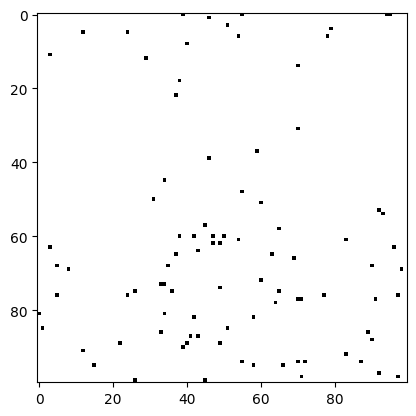

In [92]:
sf= SugarField(grf_shape_param=30, grf_damper=50)
sf.plot_field()

In [103]:
sf.grid[0,90:99] # observe: going "west to east" means increasing the second index

array([0, 0, 0, 0, 1, 1, 0, 0, 0])

In [104]:
sf.grid[90:99,0] # likewise going "north to south" means increasing the first index

array([0, 0, 0, 0, 0, 0, 0, 0, 0])

In [265]:
# going to build separate ant and hive objects
# heh could even have the hive try to coordinate among multiple sugar fields in parallel and have it cost something to generate an ant at one field
# let ants stack for now

class AntMind:
    
    def __init__(self, ant_orientation):
        """

        ant_orientation: where the ant is pointed. equivalent to the ant's previous move (ant only points where it moves). probabilities
        are 
        """
        self.has_sugar = 0 # do we have it currently?
        self.picked_up_sugar_this_turn = 0 # did we pick it up this turn?
        #self.local_grid = local_grid
        self.orientation = ant_orientation

        self.moveset = []
        #self.moveset.append(self.orientation) # where it came from!
        self.flip_orientation_dict ={'[0, 0]':[2,2],'[0, 1]':[2,1],'[0, 2]':[2,0],'[1, 0]':[1,2], '[1, 2]':[1,0], '[2, 0]':[0,2], '[2, 2]':[0,0]}

        
    def move_ant(self, local_grid):
        """
        local_grid: pass the ant a local grid consisting of where it is and the grid squares around there, including any objects
            in the local grid (objects such as pheromones or sugar). we'll also update the local grid and then pass it back out. 
            local grid is a dict of grids actually. one grid is the pheromone grid. since the grid is 3x3 numpy array, the ant
            itself is located at indices [1,1]
        """
        self.local_grid = local_grid
        self.local_grid_in = copy.deepcopy(local_grid)
        self.drop_pheromone()

        if self.has_sugar:
            # if the ant already has sugar, keep sending it home!
            self.step_home()

        else:
            self.step_forward()

        # have the HiveMind object then pull the following: self.next_move, self.local_grid
        # then HiveMind has to update the relative grid with the current local grid, and move the ant!

        self.pher_update = self.local_grid['pher'] - self.local_grid_in['pher']
        self.sugar_update = self.local_grid['sugar'] - self.local_grid_in['sugar']
        self.delta_grid = {'sugar':self.sugar_update, 'pher':self.pher_update}

    def step_forward(self):
        self.picked_up_sugar = 0
        
        if self.local_grid['sugar'][1,1] == 1: # on sugar!
            self.has_sugar = 1 # pick it up
            self.picked_up_sugar_this_turn = 1 # note you picked up up this turn
            self.local_grid['sugar'][1,1] = 0 # sugar no longer on the grid
            self.step_home() # begin walking home, also this ensures we always have a self.next_move because we need it
            #self.flip_orientation() # automagically handled in step_home function
            
        else:
            self.gen_weights() # generate the weights for moving forward
            self.explore()

        self.moveset.append(self.orientation)
        self.orientation = self.next_move # going to return the next move as well as updated grid to the grid coordinator; object updates orientation before moving
        

    def gen_weights(self):
        """
        we generate a set of weights that add to 1, assigned to each element of the grid (zeroed out for the center element)
        from these weights we'll draw a new direction to move in
        we set a greater weight to the direction we're pointed in
        """
        
        
        weights = np.zeros([3,3])
        weights[self.orientation[0],self.orientation[1]] += 1 # add 1 to currently pointed direction

        # cool little algo to get the indices of the two "neighboring" directions to our currently pointed direction
        # e.g. if we were pointed south we'd want southwest and southeast
        # basically we joystick up, down, left, and right, and throw it out if we hit the center or go off the 3x3
        potential_neighbors = [[self.orientation[0]+1,self.orientation[1]],[self.orientation[0]-1,self.orientation[1]],[self.orientation[0],self.orientation[1]+1],[self.orientation[0],self.orientation[1]-1]]
        neighbors = [el for el in potential_neighbors if (el!=[1,1] and el[0]>= 0 and el[0]<=2 and el[1]>=0 and el[1]<=2)] 

        weights[neighbors[0][0],neighbors[0][1]]+= 0.5 
        weights[neighbors[1][0],neighbors[1][1]]+= 0.5 

        weights = weights + self.local_grid['pher'] # add pheromone values directly to weights; note they're in same units!

        weights[1,1] = 0 # no need to regard weight on current location

        # don't go back the way we came
        last_position = self.flip_orientation_dict[str(self.orientation)]
        weights[last_position[0], last_position[1]] = 0 # don't go back the way we came!

        self.weights = weights / np.sum(weights) # normalize weights

    def explore(self):

        flat_weights = self.weights.flatten() # flatten the weights
        selected_flat_idx = np.random.choice(len(flat_weights), p=flat_weights) # select, based on weights which are probabilities, a direction
        selected_idx = np.unravel_index(selected_flat_idx, np.shape(self.weights)) # put that direction back into our 3x3 coords
        self.next_move = list(selected_idx)
        

    def step_home(self):
        """for now we'll just have the ant retrace its steps exactly to get home!"""
        last_move = self.moveset.pop()
        self.next_move = self.flip_orientation(last_move) # reverse
        self.orientation = self.next_move
        
        
    
    
    def flip_orientation(self):
        
        # self.flip_orientation_dict ={'[0,0]':[2,2],'[0,1]':[2,1],'[0,2]':[2,0],'[1,0]':[1,2], '[1,2]':[1,0], '[2,0]':[0,2], '[2,2]':[0,0]}
        # update dict turns whatever cardinal direction we're pointing in and returns the flip
        # imagine a 3x3 grid standing for the compass, so north is at [0,1] and south is at [2,1]; so if we input N we return S
        # just needed to define it once so moved it to init, left it here for clarity
        
        self.orientation = self.flip_orientation_dict[str(self.orientation)] # nice neat update!
        

    def drop_pheromone(self):
        self.local_grid['pher'][1,1] += 1 #local_grid is a dict


    
        
        

In [246]:
class HiveMind:

    def __init__(self, sugar_field):
        self.sf = sugar_field # 1s and 0s
        self.global_grid = {} # convert sugar field to absolute grid, which is a dict with two arrays and keys sugar and pher
        self.global_grid['sugar'] = self.sf # set sugar field
        self.global_grid['pher'] = np.zeros(np.shape(self.sf)) # initialize empty pheromone field
        
        self.spawn_ants = # what do the ants need? each ant needs an initial coordinate and an initialized mind

    def next_turn(self):
        
        self.decay_pheromones()
        self.move_ants()

    def move_ants(self):

        self.new_global_grid = copy.deepcopy(self.global_grid)
    

    def update_ant_and_grid(self, ant):
        """
        each ant's state includes the ant object as well as its coordinates
        to run the loop on the ant we need to use its coordinates to query the global grid (sugar_field)
        """
        ant_mind = ant['mind']
        ant_coord = ant['global_coord']

        ant_local_grid = self.get_local_grid_from_coord(ant_coord)
        ant_mind.move_ant(ant_local_grid) # tells you where the ant is moving and whether it got sugar

        self.update_global_grid_due_to_ant(self, ant) # drop pheromone and possibly pick up sugar irl using old coords

        ant['coord'] = self.update_ant_location(ant_mind.next_move) # update ant's coordinates irl
        
        # TODO: what order do we update the global grid in? OR how do we make updates additive? 
        
        
        # idea is to set self.new_grid = self.global_grid return the "delta grid" for each ant, add them all to self.new_grid, THEN set self.global_grid = self.new_grid
        # ok this almost will work, but what if multiple ants pick up the sugar? that doesn't work. so we want the sugar to update directly
        # to the global grid, so if one ant picks it up another cannot. but the pheromones we want to update once per turn, so that 
        # one ant's pheromone update earlier in the loop doesn't affect the next ant's update later in the loop

        #TODO: I'm doing this wrong. pheromone decay should happen in the world, not for each ant. and the world should simply
        # note an added pheromone point for the ant and possibly a sugar pickup

        
        return ant
        
    def get_local_grid_from_coord(self, coord):
        """takes in a coordinate for the global grid and returns the 3x3 local grid that the ant needs"""
        return

    def update_global_grid_due_to_ant(self, ant):
        self.global_grid['pher'][ant['coord']] += 0 # add pheromones
        if ant['mind'].picked_up_sugar:
            self.global_grid['sugar'][ant['coord']] = 0 # set sugar to 0
            
        
    def update_ant_location(self, next_move):
        """
        using the next_move value which is like a cardinal direction e.g. [0,0] for northwest, update the ant's location. handle edge cases
        """
        
    
        
        

SyntaxError: invalid syntax (2621773525.py, line 9)

In [266]:
test_pher = np.zeros([3,3])
test_pher[0,1] = 1
test_pher[2,2]=0.5
test_sugar = np.zeros([3,3])
test_grid = {'pher':test_pher, 'sugar':test_sugar}
test_ant = AntMind([0,1])

#### TODO: 

ok we actually need to provide the ant with a new context each move! so after initializing we don't need to make a first move and on initializing we don't even need to feed it a grid. but each time we move we should feed it the current grid. then, we should return the grid as well as the ant's next move. this will allow the HiveMind to then update the ant's location on the real grid (not the relative grid). The ant itself never knows where it is on the real grid (though it has its trace!)



In [268]:
test_ant.move_ant(test_grid)

In [269]:
test_ant.delta_grid

{'sugar': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'pher': array([[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]])}

In [234]:
test_ant.orientation

[2, 2]

In [235]:
str(test_ant.orientation)

'[2, 2]'

In [236]:
test_ant.weights

array([[0.        , 0.28571429, 0.        ],
       [0.        , 0.        , 0.14285714],
       [0.        , 0.14285714, 0.42857143]])

In [237]:
test_ant.local_grid['pher']

array([[0. , 1. , 0. ],
       [0. , 5. , 0. ],
       [0. , 0. , 0.5]])

In [149]:
np.random.choice(9, p=test_ant.weights.flatten())

2

In [150]:
np.unravel_index(2, np.shape(test_ant.local_grid['pher']))

(0, 2)

In [123]:
dummy_l = [[0,1],[0,-1],[-1,0],[1,0]]
[el for el in dummy_l if (el!=[1,1] and el[0]>= 0 and el[0]<=2 and el[1]>=0 and el[1]<=2)] 

[[0, 1], [1, 0]]

In [94]:
a = [0,0]
if a == [0,0]:
    b = [2,2]

In [98]:
json.loads('[1,2]')

[1, 2]

In [99]:
a = {'[1,2]':[0,1]}
a['[1,2]']

[0, 1]

In [105]:
moves = [[0,0],[0,3],[2,3]]

In [107]:
moves.pop(moves[-1])

TypeError: 'list' object cannot be interpreted as an integer

In [110]:
moves.pop()

[2, 3]

In [111]:
moves

[[0, 0], [0, 3]]

In [112]:
np.zeros([3,3])

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

### experimenting with updating / copying in numpy

from lots of pandas use I know copying vs deep copying can be a big issue. I want to make sure I'm getting it right when it comes to modifying dictionaries of objects of my making

In [256]:
a = {'a':1}
b = a
b['b'] = 2
a

# so yeah the dict is just one object it's not a deep copy

{'a': 1, 'b': 2}

In [254]:
class dummy_counter:

    def __init__(self):
        self.val = 1
        
    def update(self):
        self.val += self.val

In [258]:
dc = dummy_counter()

a = {'a':dc}
x = a['a']
x.update()
a['a'].val

#from the looks of this, the object in the dictionary also got updated in place, no need to manually assign an update

2

In [259]:
import copy

In [260]:
#copy.deepcopy

a = {'a':1}
b = copy.deepcopy(a)
b['b'] = 2
a
# deepcopy works

{'a': 1}

In [264]:
# what about with objects?

dc = dummy_counter()

a = {'a':dc}
b = copy.deepcopy(a)
b['a'].update()
print(a['a'].val)
print(b['a'].val)

# yup also works! the object itself gets deep copied, very nice

1
2


2